In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from utils import GluonConfigs

In [2]:
tf = GluonConfigs.load_data()

In [3]:
tf = tf.set_index('transect_id')
tf = tf.dropna(thresh=33)
print(f"Transects included in dataset: {tf.shape[0]}; timesteps: {tf.shape[1]}")
tf.head()

Transects included in dataset: 37111; timesteps: 33


,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
transect_id,,,,,,,,,,,,,,,,,,,,,
BOX_051_151_15,677.32043,695.66370,713.29486,682.1743,688.23425,672.13007,700.43286,693.43460,699.38560,687.97950,...,700.6640,712.41740,708.45123,740.33240,680.42510,758.35150,754.49695,763.04297,743.29680,779.41570
BOX_051_151_18,768.93800,769.23883,762.44300,755.8622,761.79663,760.51710,763.30505,761.81360,769.22100,765.47060,...,763.1057,759.72600,766.23150,770.77130,798.26830,797.99615,803.90950,797.90780,798.18830,803.68256
BOX_051_151_21,711.41626,684.20540,695.49817,701.6695,705.29990,703.61470,707.69403,692.90360,704.68280,704.99945,...,825.8698,820.51720,820.68680,842.18097,850.45460,775.96700,883.04240,867.92426,877.37415,874.50244
BOX_051_151_30,795.81573,820.63700,799.72380,799.8664,823.56260,822.07300,823.56800,823.73300,824.58400,824.33360,...,823.7820,823.15674,823.65790,821.31860,818.85803,817.31220,822.92970,818.73350,822.18480,818.73480
BOX_051_151_32,242.70204,238.05159,229.93718,244.0620,247.68105,257.49900,302.69217,301.27722,301.12033,316.40414,...,301.1231,313.63553,313.09814,312.90347,306.18658,294.18326,297.23654,302.88650,323.85840,304.36823


In [4]:
tf = tf.sample(1000)

In [5]:
sites = pd.read_csv("/media/storage/data/shorelines/sites-gluonts-prepared.csv")
sites = sites.loc[sites['transect_id'].isin(tf.index)]

logs = np.log(sites['changerate_unc'].values)
sites['changerate_cat'] = pd.qcut(logs, q=10, labels=range(10))

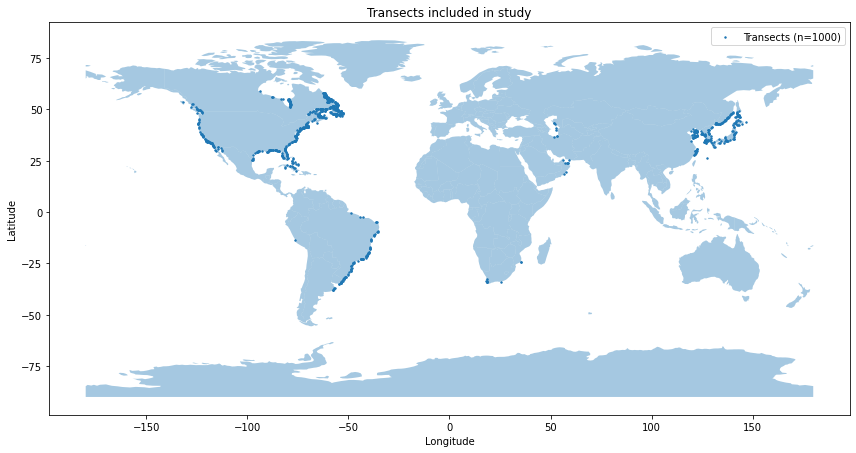

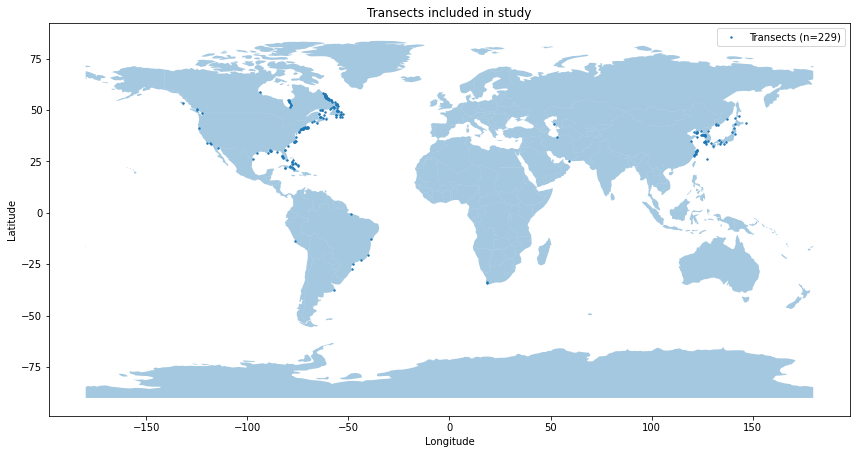

In [7]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

def make_geodataframe(df: pd.DataFrame) -> gpd.GeoDataFrame:
    crs = CRS("epsg:4326")
    geometries = gpd.points_from_xy(df.Intersect_lon, df.Intersect_lat)
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometries)

def plot_spatial_distribution(gdf: gpd.GeoDataFrame) -> None:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    world.plot(ax=ax, alpha=.4)
    gdf.plot(markersize=2, ax=ax, label=f"Transects (n={len(gdf)})")
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Transects included in study')
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
geosites = make_geodataframe(sites)
plot_spatial_distribution(geosites)
plot_spatial_distribution(make_geodataframe(geosites.groupby('coastline_idint').first()))


In [8]:
def get_timestamp_first_obs(series: pd.Series) -> pd.Timestamp:
  yr = series.first_valid_index()
  return pd.Timestamp(f"01-01-{yr}", freq='1Y')

metadata = {'num_series': len(tf),
            'num_steps': len(tf.columns),
            'prediction_length': 7,
            'freq': "AS",
            'start': [pd.Timestamp("01-01-1984", freq='AS') for _ in range(len(tf))],
            'item_id': tf.index.values,
            'context_length': 26
            }

In [9]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset

train_ds = ListDataset(
    [
     {
         FieldName.TARGET: target,
         FieldName.START: start,
         FieldName.ITEM_ID: item_id,
         FieldName.FEAT_STATIC_CAT: [fsc1, fsc2],
         FieldName.FEAT_STATIC_REAL: [fsr]
      }
     
     for (target, start, item_id, fsc1, fsc2, fsr) in zip(tf.values[:, :-metadata['prediction_length']],
                                        metadata['start'], 
                                        metadata['item_id'],
                                        sites['coastline_idint'].values,
                                        sites['changerate_cat'].values,
                                        sites['changerate_unc'].values)
    ], freq=metadata['freq'])

test_ds = ListDataset(
    [
     {
         FieldName.TARGET: target,
         FieldName.START: start,
         FieldName.ITEM_ID: item_id,
         FieldName.FEAT_STATIC_CAT: [fsc1, fsc2],
         FieldName.FEAT_STATIC_REAL: [fsr]
      }
     
     for (target, start, item_id, fsc1, fsc2, fsr) in zip(tf.values,
                                        metadata['start'], 
                                        metadata['item_id'],
                                        sites['coastline_idint'].values,
                                        sites['changerate_cat'].values,
                                        sites['changerate_unc'].values)
    ], freq=metadata['freq'])

In [13]:
from pprint import pprint
pprint(next(iter(train_ds)))
print("")
pprint(next(iter(test_ds)))

{'feat_static_cat': array([7427,    5], dtype=int32),
 'feat_static_real': array([0.24320982], dtype=float32),
 'item_id': 'BOX_161_294_158',
 'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('1984-01-01 00:00:00', freq='AS-JAN'),
 'target': array([696.4335 , 690.9587 , 693.3324 , 693.7312 , 682.71655, 712.9946 ,
       697.8126 , 694.744  , 691.4246 , 693.50323, 697.8424 , 690.20636,
       700.6103 , 717.2181 , 704.3951 , 706.66327, 728.46606, 723.55707,
       716.9954 , 714.306  , 717.40375, 714.02435, 707.3062 , 706.479  ,
       694.68616, 709.5022 ], dtype=float32)}

{'feat_static_cat': array([7427,    5], dtype=int32),
 'feat_static_real': array([0.24320982], dtype=float32),
 'item_id': 'BOX_161_294_158',
 'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('1984-01-01 00:00:00', freq='AS-JAN'),
 'target': array([696.4335 , 690.9587 , 693.3324 , 693.7312 , 682.71655, 712.9946 ,
       697.8126 , 694.744  , 691.4246 , 693.50323, 697.842

In [14]:
from pprint import pprint

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.trainer import Trainer
from gluonts.model.wavenet import WaveNetEstimator

estimator = WaveNetEstimator(
    prediction_length=7,
    freq='12M',
    cardinality=[len(sites['coastline_idint'].unique()), len(sites['changerate_cat'].unique())],
    trainer=Trainer(ctx="cpu",
                    epochs=10,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)


predictor = estimator.train(train_ds)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

pprint(agg_metrics)

/media/storage/dev/shorelineforecasting/shorelineforecasting/unstable/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: gluonts.trainer is deprecated. Use gluonts.mx.trainer instead.
  """
  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1000/1000 [00:00<00:00, 18040.09it/s]


{'Coverage[0.1]': 0.28571428571428564,
 'Coverage[0.5]': 0.6995714285714285,
 'Coverage[0.9]': 0.9171428571428571,
 'MAE_Coverage': 0.1341428571428571,
 'MAPE': 0.06240829941813073,
 'MASE': 1.7858209088410661,
 'MSE': 13476.13612614877,
 'MSIS': 18.90770741402098,
 'ND': 0.03317744675318994,
 'NRMSE': 0.15856370517849783,
 'OWA': nan,
 'QuantileLoss[0.1]': 102308.8477344513,
 'QuantileLoss[0.5]': 170027.79167556763,
 'QuantileLoss[0.9]': 94660.01450271605,
 'RMSE': 116.08676120104639,
 'abs_error': 170027.7900238037,
 'abs_target_mean': 732.1143326612201,
 'abs_target_sum': 5124800.32862854,
 'mean_absolute_QuantileLoss': 122332.21797091165,
 'mean_wQuantileLoss': 0.023870631073669418,
 'sMAPE': 0.034829983593448785,
 'seasonal_error': 13.316511450805665,
 'wQuantileLoss[0.1]': 0.01996347977948058,
 'wQuantileLoss[0.5]': 0.0331774470754979,
 'wQuantileLoss[0.9]': 0.018470966366029764}


In [21]:
def subtract_dict_values(a: dict, b: dict) -> dict:
    return {k: a[k]-b[k] for k in a}

{'MSE': 1708.6116277597716,
 'abs_error': 4324372.385995865,
 'abs_target_sum': 191056381.64076424,
 'abs_target_mean': 735.4630380702072,
 'seasonal_error': 13.435315968737909,
 'MASE': 1.3670798565577758,
 'MAPE': 0.04165267455942459,
 'sMAPE': 0.027123216623721743,
 'OWA': nan,
 'MSIS': 19.424906963320595,
 'QuantileLoss[0.1]': 2337388.3403209206,
 'Coverage[0.1]': 0.08202804713273307,
 'QuantileLoss[0.5]': 4324372.388644218,
 'Coverage[0.5]': 0.4765702891326022,
 'QuantileLoss[0.9]': 3212255.8118492123,
 'Coverage[0.9]': 0.8796506234193172,
 'RMSE': 41.335355662674196,
 'NRMSE': 0.0562031720467349,
 'ND': 0.022634011744903718,
 'wQuantileLoss[0.1]': 0.012234023905654298,
 'wQuantileLoss[0.5]': 0.02263401175876535,
 'wQuantileLoss[0.9]': 0.01681313015698732,
 'mean_wQuantileLoss': 0.017227055273802323,
 'MAE_Coverage': 0.020583680105115854}

In [20]:
met

{'MSE': 1671.4134204694817,
 'abs_error': 4371830.318192482,
 'abs_target_sum': 191056381.64076424,
 'abs_target_mean': 735.4630380702072,
 'seasonal_error': 13.435315968737909,
 'MASE': 1.4017678200351589,
 'MAPE': 0.041053146580880474,
 'sMAPE': 0.027405175077519696,
 'OWA': nan,
 'MSIS': 19.90674084510169,
 'QuantileLoss[0.1]': 2563990.2273771763,
 'Coverage[0.1]': 0.05075507069525016,
 'QuantileLoss[0.5]': 4371830.316298723,
 'Coverage[0.5]': 0.41355855214279935,
 'QuantileLoss[0.9]': 3194315.1789988037,
 'Coverage[0.9]': 0.9033786670875403,
 'RMSE': 40.88292333566035,
 'NRMSE': 0.05558800540532082,
 'ND': 0.022882409269179303,
 'wQuantileLoss[0.1]': 0.013420071108632978,
 'wQuantileLoss[0.5]': 0.022882409259267263,
 'wQuantileLoss[0.9]': 0.01671922786125484,
 'mean_wQuantileLoss': 0.017673902743051695,
 'MAE_Coverage': 0.04635501474983026}

In [32]:
   

    
    
subtract_dict_values(agg_metrics, met)

{'MSE': 37.19820729028993,
 'abs_error': -47457.93219661713,
 'abs_target_sum': 0.0,
 'abs_target_mean': 0.0,
 'seasonal_error': 0.0,
 'MASE': -0.03468796347738312,
 'MAPE': 0.0005995279785441163,
 'sMAPE': -0.0002819584537979529,
 'OWA': nan,
 'MSIS': -0.4818338817810961,
 'QuantileLoss[0.1]': -226601.8870562557,
 'Coverage[0.1]': 0.031272976437482905,
 'QuantileLoss[0.5]': -47457.927654504776,
 'Coverage[0.5]': 0.06301173698980284,
 'QuantileLoss[0.9]': 17940.632850408554,
 'Coverage[0.9]': -0.02372804366822312,
 'RMSE': 0.4524323270138453,
 'NRMSE': 0.0006151666414140819,
 'ND': -0.00024839752427558565,
 'wQuantileLoss[0.1]': -0.0011860472029786798,
 'wQuantileLoss[0.5]': -0.00024839750050191164,
 'wQuantileLoss[0.9]': 9.390229573248005e-05,
 'mean_wQuantileLoss': -0.0004468474692493722,
 'MAE_Coverage': -0.025771334644714407}

In [14]:
from pprint import pprint

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.trainer import Trainer
from gluonts.model.deepar import DeepAREstimator

estimator = DeepAREstimator(
    prediction_length=metadata['prediction_length'],
    context_length=metadata['context_length'],
    freq='12M',
    use_feat_static_real=True,
    use_feat_static_cat=True,
    cardinality=[len(sites['coastline_idint'].unique())],
    trainer=Trainer(ctx="cpu",
                    epochs=10,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)


predictor = estimator.train(train_ds)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

pprint(agg_metrics)




  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1000/1000 [00:00<00:00, 14402.28it/s]


{'Coverage[0.1]': 0.2061428571428571,
 'Coverage[0.5]': 0.698,
 'Coverage[0.9]': 0.9081428571428571,
 'MAE_Coverage': 0.10409523809523806,
 'MAPE': 0.4753569176552284,
 'MASE': 1.9511277066860575,
 'MSE': 3465.638200680869,
 'MSIS': 23.227854192486834,
 'ND': 0.035366316204698094,
 'NRMSE': 0.0818572482060664,
 'OWA': nan,
 'QuantileLoss[0.1]': 107015.90916290286,
 'QuantileLoss[0.5]': 178041.94791030884,
 'QuantileLoss[0.9]': 115013.84558944701,
 'RMSE': 58.86967131453061,
 'abs_error': 178041.94733428955,
 'abs_target_mean': 719.1748147498539,
 'abs_target_sum': 5034223.703248978,
 'mean_wQuantileLoss': 0.02649012878287876,
 'sMAPE': 0.045259390639613366,
 'seasonal_error': 14.004077765502931,
 'wQuantileLoss[0.1]': 0.02125767853618367,
 'wQuantileLoss[0.5]': 0.03536631631911877,
 'wQuantileLoss[0.9]': 0.022846391493333836}


In [13]:
agg_metrics_1 = agg_metrics

In [15]:
{key:agg_metrics_1[key]-agg_metrics[key] for key in agg_metrics_1}

{'MSE': 116.39628606360293,
 'abs_error': 3315.592727661133,
 'abs_target_sum': 0.0,
 'abs_target_mean': 0.0,
 'seasonal_error': 0.0,
 'MASE': 0.053675535225835125,
 'MAPE': -0.008176735430317661,
 'sMAPE': 0.0014846074964902853,
 'OWA': nan,
 'MSIS': 3.1744468682476423,
 'QuantileLoss[0.1]': 4507.927330017061,
 'Coverage[0.1]': -0.16571428571428568,
 'QuantileLoss[0.5]': 3315.5926094055176,
 'Coverage[0.5]': -0.4082857142857143,
 'QuantileLoss[0.9]': 2410.79516906738,
 'Coverage[0.9]': -0.04500000000000004,
 'RMSE': 0.9804288252725968,
 'NRMSE': 0.0013632691317390089,
 'ND': 0.0006586105272837414,
 'wQuantileLoss[0.1]': 0.0008954562998675919,
 'wQuantileLoss[0.5]': 0.0006586105037934067,
 'wQuantileLoss[0.9]': 0.0004788812160873013,
 'mean_wQuantileLoss': 0.0006776493399160977,
 'MAE_Coverage': -0.0018571428571427795}

In [140]:
agg_metrics_old = agg_metrics

In [14]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

# transformation = create_transformation(custom_ds_metadata['freq'],
#                                        2 * custom_ds_metadata['prediction_length'], # can be any appropriate value
#                                        custom_ds_metadata['prediction_length'])

# train_tf = transformation(iter(train_ds), is_train=True)

In [16]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

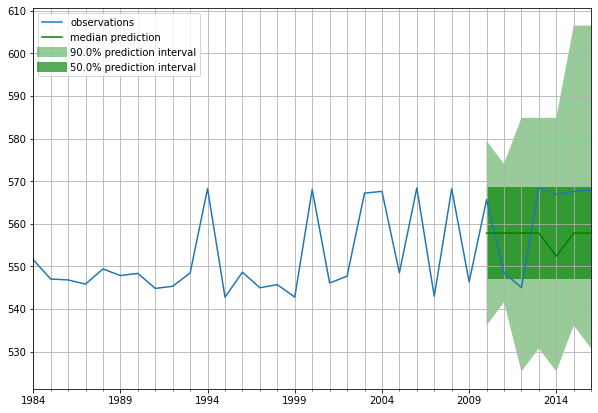

In [32]:
import numpy as np

n = np.random.randint(0, len(tf))
forecast_entry = forecasts[n]
ts_entry = tss[n]

plot_prob_forecasts(ts_entry, forecast_entry)

In [57]:
import pprint
from functools import partial


from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.seq2seq import MQCNNEstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

epochs = 10
num_batches_per_epoch = 50
count = 0

estimators = [
    partial(
        SimpleFeedForwardEstimator,
        freq=metadata["freq"],
        trainer=Trainer(
            epochs=epochs, num_batches_per_epoch=num_batches_per_epoch
        ),
    ),
    partial(
        DeepAREstimator,
        freq="12M",
        trainer=Trainer(
            epochs=epochs, num_batches_per_epoch=num_batches_per_epoch
        ),
    ),
    partial(
        DeepAREstimator,
        freq="12M",
        distr_output=PiecewiseLinearOutput(8),
        trainer=Trainer(
            epochs=epochs, num_batches_per_epoch=num_batches_per_epoch
        ),
    ),
    partial(
        MQCNNEstimator,
        freq=metadata["freq"],
        trainer=Trainer(
            epochs=epochs, num_batches_per_epoch=num_batches_per_epoch
        ),
    ),
]

def evaluate(estimator):
    estimator = estimator(
        prediction_length=metadata['prediction_length'],
        context_length=metadata['context_length']
#         freq=metadata["freq"]

    )

    print(f"evaluating {estimator}")

    predictor = estimator.train(train_ds)

    forecast_it, ts_it = make_evaluation_predictions(
        test_ds, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(test_ds)
    )
    
    item_metrics["estimator_id"] = count
    item_metrics["estimator"] = type(estimator).__name__
    agg_metrics["estimator"] = type(estimator).__name__
    
    return item_metrics, agg_metrics


item_metrics_list = []
agg_metrics_list = []
for estimator in estimators:
    count+=1
    # catch exceptions that are happening during training to avoid failing the whole evaluation
    try:
        item_metrics, agg_metrics = evaluate(estimator)

        item_metrics_list.append(item_metrics)
        agg_metrics_list.append(agg_metrics)

    except Exception as e:
        print(f"\n---> ---> ---> --->\nException error:\n")
        print(str(e))
        print("\n<--- <--- <--- <---\n")



  0%|          | 0/50 [00:00<?, ?it/s]

evaluating gluonts.model.simple_feedforward._estimator.SimpleFeedForwardEstimator(batch_normalization=False, context_length=21, distr_output=gluonts.distribution.student_t.StudentTOutput(), freq="AS", mean_scaling=True, num_hidden_dimensions=None, num_parallel_samples=100, prediction_length=7, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=None, cell_type="lstm", context_length=21, distr_output=gluonts.distribution.student_t.StudentTOutput(), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=7, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=False, use_feat_static_real=False)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

evaluating gluonts.model.deepar._estimator.DeepAREstimator(cardinality=None, cell_type="lstm", context_length=21, distr_output=gluonts.distribution.piecewise_linear.PiecewiseLinearOutput(num_pieces=8), dropout_rate=0.1, embedding_dimension=None, freq="12M", lags_seq=None, num_cells=40, num_layers=2, num_parallel_samples=100, prediction_length=7, scaling=True, time_features=None, trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08), use_feat_dynamic_real=False, use_feat_static_cat=False, use_feat_static_real=False)
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

evaluating gluonts.model.seq2seq._mq_dnn_estimator.MQCNNEstimator(context_length=21, freq="AS", mlp_final_dim=20, mlp_hidden_dimension_seq=[], prediction_length=7, quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], trainer=gluonts.trainer._base.Trainer(batch_size=32, clip_gradient=10.0, ctx=None, epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08))
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 447.56it/s]


In [58]:
# item_metrics_1 = pd.concat(item_metrics_list)
# item_metrics_2 = pd.concat(item_metrics_list)
item_metrics_3 = pd.concat(item_metrics_list)

In [60]:
for estimator_id in item_metrics_3["estimator_id"].unique():
    tmp = item_metrics_3.loc[item_metrics_3["estimator_id"]==estimator_id]
    for c in list(tmp.select_dtypes(include=[np.float])):
        print(f"{c}: {tmp[c].mean()}")
    print("-"*100)

MSE: 5009.4751184082015
abs_error: 411.93402496337893
abs_target_sum: 5220.404765625
abs_target_mean: 745.7721093749999
seasonal_error: 14.263550488281249
MASE: 6.575859326412978
MAPE: 0.08130623774879935
sMAPE: 0.0781049045484472
OWA: nan
MSIS: 36.59169529764349
QuantileLoss[0.1]: 265.63124079895016
Coverage[0.1]: 0.69
QuantileLoss[0.2]: 393.03487878417974
Coverage[0.2]: 0.7985714285714286
QuantileLoss[0.3]: 431.62629397583004
Coverage[0.3]: 0.8142857142857145
QuantileLoss[0.4]: 432.5068855590821
Coverage[0.4]: 0.8442857142857144
QuantileLoss[0.5]: 411.93402542114256
Coverage[0.5]: 0.8742857142857143
QuantileLoss[0.6]: 370.86615264892583
Coverage[0.6]: 0.9085714285714286
QuantileLoss[0.7]: 319.5338490905762
Coverage[0.7]: 0.9342857142857143
QuantileLoss[0.8]: 253.01382598876953
Coverage[0.8]: 0.9514285714285714
QuantileLoss[0.9]: 165.2691303710937
Coverage[0.9]: 0.9685714285714286
----------------------------------------------------------------------------------------------------
MSE:

In [52]:
for estimator_id in item_metrics_2["estimator_id"].unique():
    tmp = item_metrics_1.loc[item_metrics_1["estimator_id"]==estimator_id]
    for c in list(tmp.select_dtypes(include=[np.float])):
        print(f"{c}: {tmp[c].mean()}")
    print("-"*100)

MSE: 1559.255603441511
abs_error: 150.4295034790039
abs_target_sum: 5220.404765625
abs_target_mean: 745.7721093749999
seasonal_error: 14.263550488281249
MASE: 1.77530130926222
MAPE: 0.031214420516022415
sMAPE: 0.031611409034938455
OWA: nan
MSIS: 23.348527232910527
QuantileLoss[0.1]: 76.97041366577149
Coverage[0.1]: 0.13285714285714284
QuantileLoss[0.2]: 108.06914636230468
Coverage[0.2]: 0.23714285714285707
QuantileLoss[0.3]: 129.04841876220704
Coverage[0.3]: 0.3614285714285714
QuantileLoss[0.4]: 142.53971063232422
Coverage[0.4]: 0.47571428571428565
QuantileLoss[0.5]: 150.42950225830077
Coverage[0.5]: 0.57
QuantileLoss[0.6]: 151.26296734619143
Coverage[0.6]: 0.6642857142857141
QuantileLoss[0.7]: 146.99906396484377
Coverage[0.7]: 0.75
QuantileLoss[0.8]: 134.555701171875
Coverage[0.8]: 0.8214285714285714
QuantileLoss[0.9]: 108.71574804687502
Coverage[0.9]: 0.8857142857142857
----------------------------------------------------------------------------------------------------
MSE: 1710.7265

In [44]:

for estimator_id in item_metrics_1["estimator_id"].unique():
    tmp = item_metrics_1.loc[item_metrics_1["estimator_id"]==estimator_id]
    for c in list(tmp.select_dtypes(include=[np.float])):
        print(f"{c}: {tmp[c].mean()}")
    print("-"*100)
    


MSE: 1559.255603441511
abs_error: 150.4295034790039
abs_target_sum: 5220.404765625
abs_target_mean: 745.7721093749999
seasonal_error: 14.263550488281249
MASE: 1.77530130926222
MAPE: 0.031214420516022415
sMAPE: 0.031611409034938455
OWA: nan
MSIS: 23.348527232910527
QuantileLoss[0.1]: 76.97041366577149
Coverage[0.1]: 0.13285714285714284
QuantileLoss[0.2]: 108.06914636230468
Coverage[0.2]: 0.23714285714285707
QuantileLoss[0.3]: 129.04841876220704
Coverage[0.3]: 0.3614285714285714
QuantileLoss[0.4]: 142.53971063232422
Coverage[0.4]: 0.47571428571428565
QuantileLoss[0.5]: 150.42950225830077
Coverage[0.5]: 0.57
QuantileLoss[0.6]: 151.26296734619143
Coverage[0.6]: 0.6642857142857141
QuantileLoss[0.7]: 146.99906396484377
Coverage[0.7]: 0.75
QuantileLoss[0.8]: 134.555701171875
Coverage[0.8]: 0.8214285714285714
QuantileLoss[0.9]: 108.71574804687502
Coverage[0.9]: 0.8857142857142857
----------------------------------------------------------------------------------------------------
MSE: 1710.7265

In [17]:
for estimator in item_metrics["estimator"].unique():
    metrics = item_metrics.loc[item_metrics["estimator"]==estimator]
    print("-"*100)
    print(estimator)
    print("-"*100)
    for i in list(metrics.select_dtypes(include=[np.float])):
        print(f"{i}: {metrics[i].mean()}")

# item_metrics.loc[item_metrics["estimator"]==]

----------------------------------------------------------------------------------------------------
SimpleFeedForwardEstimator
----------------------------------------------------------------------------------------------------
MSE: 1788.3301931946182
abs_error: 133.1326848184222
abs_target_sum: 5148.112319531485
abs_target_mean: 735.4446170759264
seasonal_error: 13.435122173964707
MASE: 1.667778448788371
MAPE: 0.05709880675858418
sMAPE: 0.030288370371675595
OWA: nan
MSIS: 20.68501799799031
QuantileLoss[0.1]: 69.40406823610792
Coverage[0.1]: 0.1147992178117205
QuantileLoss[0.2]: 97.03762833518596
Coverage[0.2]: 0.19863809934407045
QuantileLoss[0.3]: 115.37920558483184
Coverage[0.3]: 0.27626412712099285
QuantileLoss[0.4]: 127.1335866165408
Coverage[0.4]: 0.3473193114279555
QuantileLoss[0.5]: 133.1326848286497
Coverage[0.5]: 0.41818587749822933
QuantileLoss[0.6]: 134.08519863895262
Coverage[0.6]: 0.48530702429710837
QuantileLoss[0.7]: 128.24997625284655
Coverage[0.7]: 0.5691228097188432

In [13]:
item_metrics.to_pickle("/media/storage/data/shorelines/metrics-gluonts.pkl")

In [12]:
eval_item_dict_list[0]["item_metrics"]['MAPE'].mean()

NameError: name 'eval_item_dict_list' is not defined

In [ ]:
for i in eval_item_dict_list:
  metrics = i["item_metrics"]
  print(metrics["MAPE"].mean())
  print(max(metrics["MAPE"]))
  print(min(metrics["MAPE"]))
  print("---"*10)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
for i in eval_item_dict_list:
  metrics = i["item_metrics"]
  metrics["MSE"].plot(kind='hist')

plt.show()



In [ ]:
ff# all_metrics = pd.concat(item_metrics_list)
all_metrics['MAPE'].mean()

## Sample dataset

In [ ]:
from gluonts.dataset.artificial import ConstantDataset


metadata = {'num_series': 1000, 
            'num_steps': 33, 
            'prediction_length': 7,
            'freq': '365D',   # not 1Y for DeepAR freq requirements
            'start': [pd.Timestamp("01-01-1984", freq='365D') for _ in range(len(tf))]
            }

ds_generator = ConstantDataset(num_timeseries = metadata['num_series'],
                              num_steps = metadata['num_steps'],
                              freq = metadata['freq'],
                              start = '1984-01-01 00:00:00')

constant_ds = ds_generator.generate()
train_ds = constant_ds.train
test_ds = constant_ds.test

In [ ]:
# from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
# from gluonts.trainer import Trainer

# estimator = SimpleFeedForwardEstimator(
#     num_hidden_dimensions=[10],
#     prediction_length=metadata['prediction_length'],
#     context_length=metadata['prediction_length'] * 2,
#     freq=metadata['freq'],
#     trainer=Trainer(ctx="cpu", 
#                     epochs=20, 
#                     learning_rate=1e-3, 
#                     hybridize=False, 
#                     num_batches_per_epoch=100
#                    )
# )

# predictor = estimator.train(train_ds)




from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=metadata['prediction_length'],
    freq="M",
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    # cardinality=stat_cat_cardinalities,
    trainer=Trainer(
        learning_rate=1e-3,
        epochs=10,
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)



In [ ]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

In [ ]:
# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

# first entry of the time series list
ts_entry = tss[0]
forecast_entry =  forecasts[0]
test_ds_entry = next(iter(test_ds))

# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

# first 5 values
test_ds_entry['target'][:5]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

In [ ]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 100 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

for forecast_entry, ts_entry in zip(forecasts[:30], tss[:30]):
  plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
print(len(tss))
print(len(forecasts))
print(len(test_ds))



In [39]:
count = 0
for i in range(4):
    count+=1
    print()

SyntaxError: invalid syntax (<ipython-input-39-22c55397c9db>, line 3)

In [ ]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss[:10000]), iter(forecasts[:10000]), num_series=10000)
print(json.dumps(agg_metrics, indent=4))

In [ ]:
item_metrics.head()

In [ ]:
min(item_metrics['MAPE'])